<a href="https://colab.research.google.com/github/gpricechristie/introductionToClinicalTrials/blob/main/simulateSurvivalData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulation of a clinical trial cohort to demonstrate trial design
Basic analysis to create simple (non-censored) survival data with simple exponential baseline hazard and hazard to various risk factors that  can be used to demonstrate confounding, randomisation and selection bias.

Patient factors to consider will be
* Age
* Sex
* Performance status
* Cancer stage
* GTV Volume

We will consider lung cancer and take hazard ratio estimates from cardiac toxicity papers (10.1016/j.ejca.2017.07.053). Add in an HR for respose to new radiotherapy regimen
* Age HR - 1.01/year
* Sex HR - (ref female), 1.2
* Performance status HR - (ref 0), 1.3 (1), 1.55 (2), 1.82 (3+)
* Cancer stage HR - (ref 1), 1.3 (2), 1.5 (3), 2.0 (4)
* GTV Volume HR - 1.01 / cm3
* Treatment effect HR - 1.3


Load libraries

In [1]:
library(survival)
library(ggplot2)

Set basic parameters


*   Number of patients (nbrPats)
*   Hazards for different factors (hr_X)
*   Baseline hazards (h_0 - uniform as exponential cumulative baseline)



In [45]:
nbrPats = 1000
hr_age=1.01
hr_sex=1.2
hr_ps1=1.3
hr_ps2=1.55
hr_ps3=1.82
hr_stage2=1.3
hr_stage3=1.5
hr_stage4=2.0
hr_gtv=1.01
hr_treat=1.3
h_0=0.001

Define the distribution of characteristics across the patient population

Start with weighted random assignment approximating distributions seen in Christie data
* Age - normal distribution with mean 70 and sd 10
* PS - sampled with weights 0.15, 0.45, 0.4, 0.1
* stage - sampled with weights 0.5, 0.125, 0.3, 0.075
* sex - sampled with weights 0.4, 0.6
* log gtv - normal distribution with mean 4 and sd 1

Will need to be weighted to reasonable distributions and will need to include some correlations (eg stage and GTV)

In [3]:
ps=sample(c(0,1,2,3), nbrPats, replace=TRUE, prob=c(0.15, 0.45, 0.4, 0.1))
patients = data.frame(ps=ps)

age=rnorm(nbrPats,mean=70,sd=10)
patients$age=age

stage=sample(c(1,2,3,4), nbrPats, replace=TRUE, prob=c(0.5, 0.125, 0.3, 0.075))
patients$stage=stage

sex=sample(c('male','female'), nbrPats, replace=TRUE, prob=c(0.6, 0.4))
patients$sex=sex

logGtv = rnorm(nbrPats,mean=3, sd=1)
patients$gtv=exp(logGtv)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


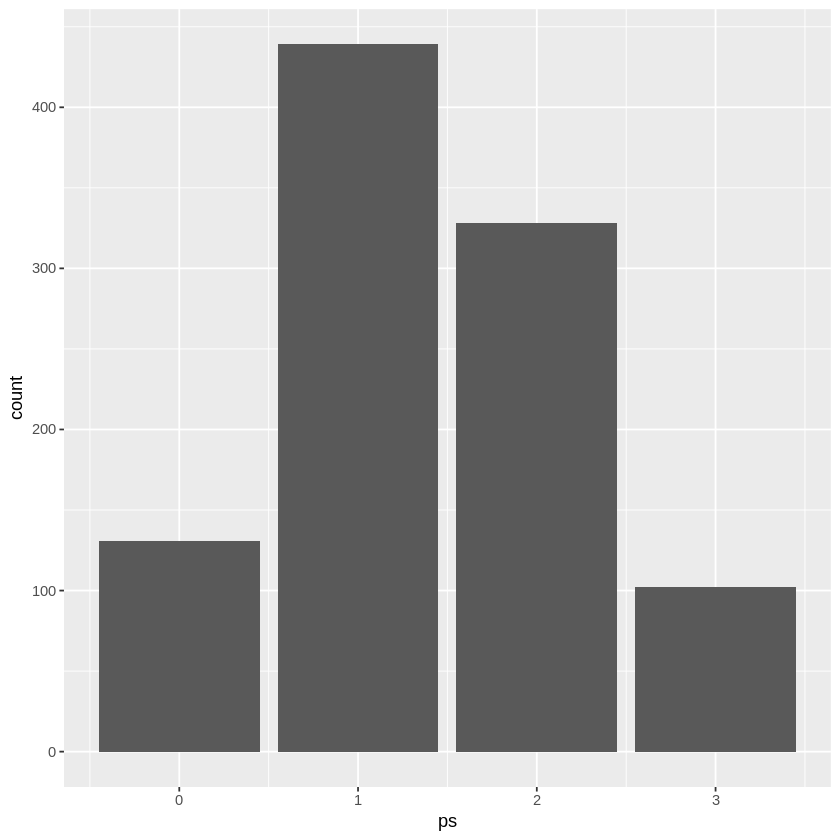

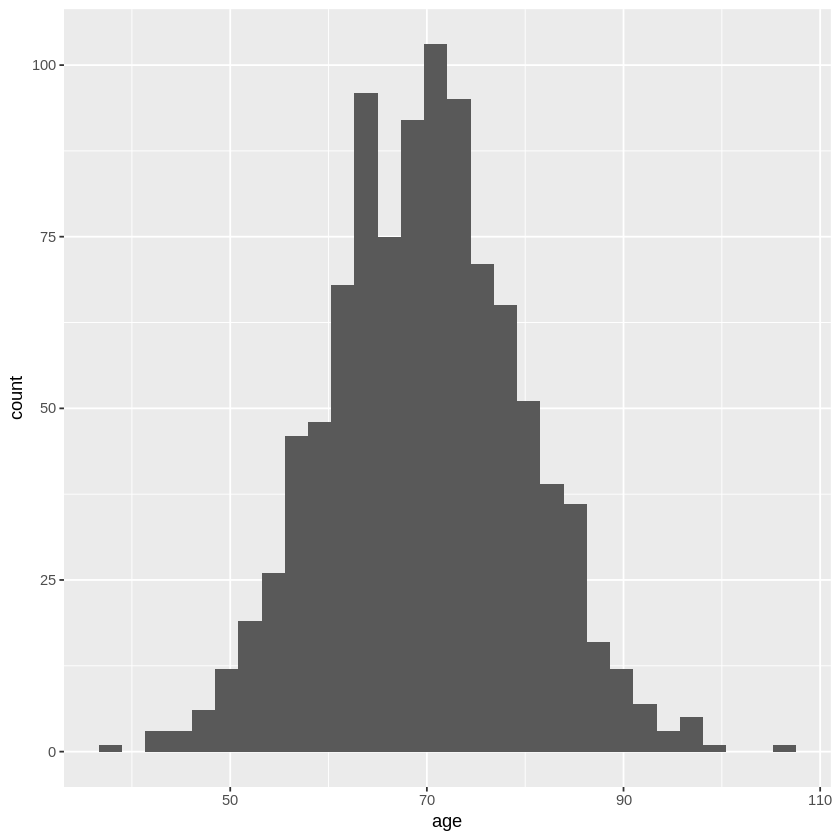

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


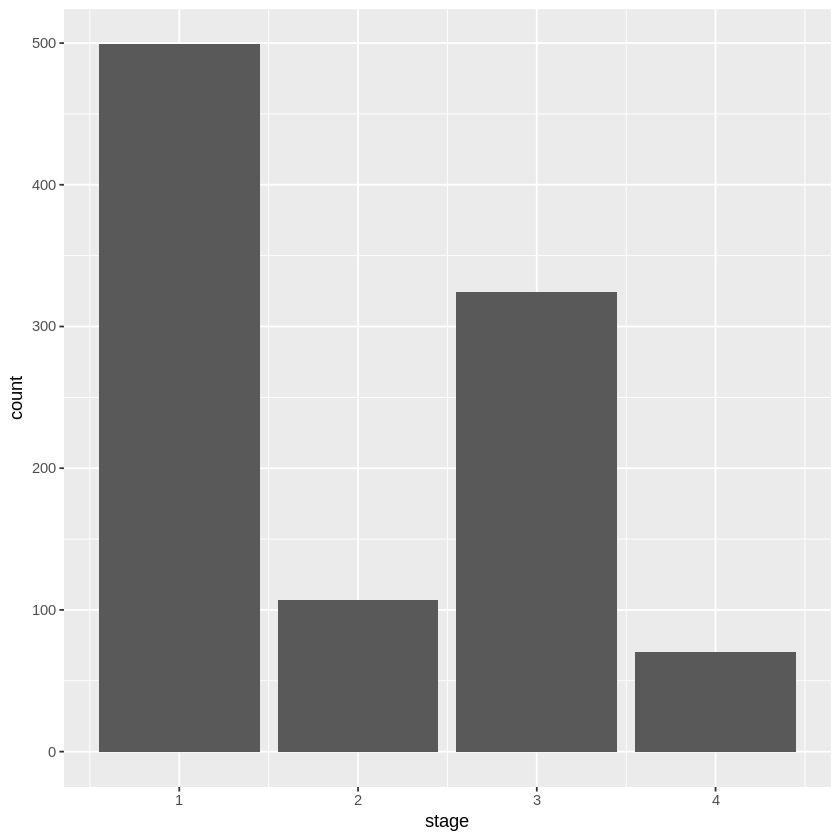

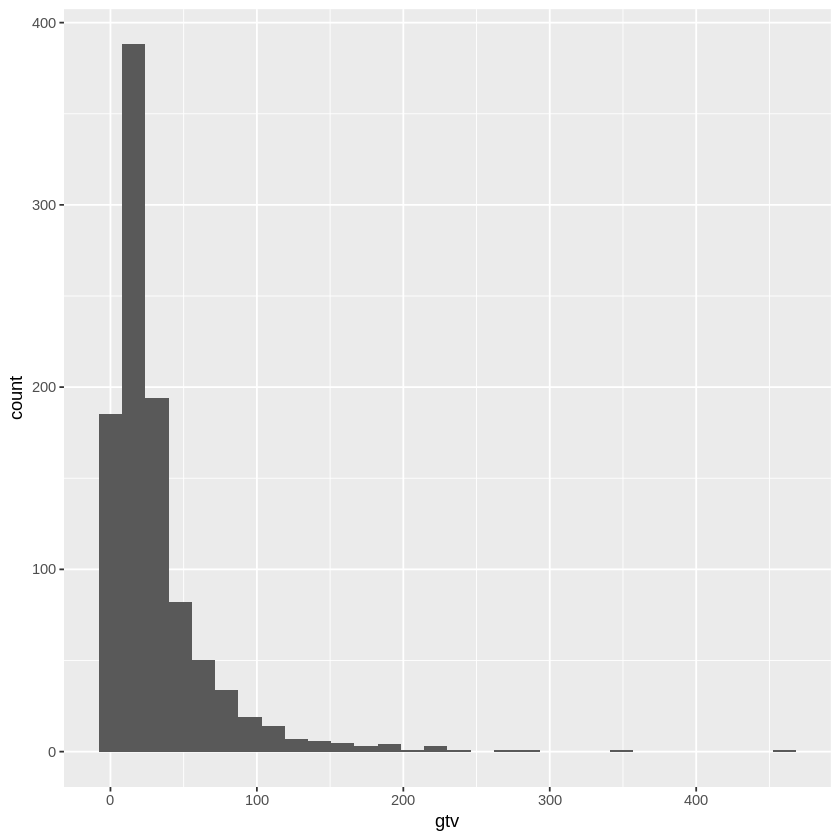

In [4]:
ggplot(patients,aes(x=ps)) +
  geom_bar(stat='count')

ggplot(patients,aes(x=age)) +
  geom_histogram()

ggplot(patients,aes(x=stage)) +
  geom_bar(stat='count')

ggplot(patients,aes(x=gtv)) +
  geom_histogram()

Create time vector for period we are interested in (3 years)

In [5]:
time=seq(0,365*3)

Calculate cumulative baseline hazard

In [46]:
H_0 = h_0 * time

Create array of hazards as a function of time for different prognostic indicies

Hazard for patient i: h_i = H_0 * exp(B_i * x_i)

B_i *x_i = prognostic index for patient i



First calculate prognostic index for each patient

Natural log of HRs to create the beta coefficients

For continuous variables (eg age) the reference value is the mean, for categorical variables, reference (eg stage) is lowest risk



In [21]:
patients$age_pi = (patients$age - mean(patients$age))*log(hr_age)

patients$sex_pi = rep(log(1.0),nbrPats)
patients$sex_pi[which(patients$sex == 'male')] = rep(log(hr_sex),sum(patients$sex == 'male'))

patients$ps_pi = rep(log(1.0),nbrPats)
patients$ps_pi[which(patients$ps == 1)] = rep(log(hr_ps1),sum(patients$ps == 1))
patients$ps_pi[which(patients$ps == 2)] = rep(log(hr_ps2),sum(patients$ps == 2))
patients$ps_pi[which(patients$ps == 3)] = rep(log(hr_ps3),sum(patients$ps == 3))

patients$stage_pi = rep(log(1.0),nbrPats)
patients$stage_pi[which(patients$stage == 2)] = rep(log(hr_stage2),sum(patients$stage == 2))
patients$stage_pi[which(patients$stage == 3)] = rep(log(hr_stage3),sum(patients$stage == 3))
patients$stage_pi[which(patients$stage == 4)] = rep(log(hr_stage4),sum(patients$stage == 4))

patients$log_gtv_pi = (log(patients$gtv) - mean(log(patients$gtv)))*log(hr_gtv)

patients$progInd = patients$age_pi + patients$sex_pi + patients$ps_pi + patients$stage_pi + patients$log_gtv_pi

Calculate the individual hazard per patient over time

In [47]:
hazard = array(dim=c(length(time),nrow=nbrPats))
for(i in 1:nbrPats){
  hazard[,i] =  H_0 * exp(patients$progInd[i])
}

Calculate survival probabilities per patient from their hazard and the baseline S_i = exp(-hazard)

Plot to see if it looks sensible[link text](https://)



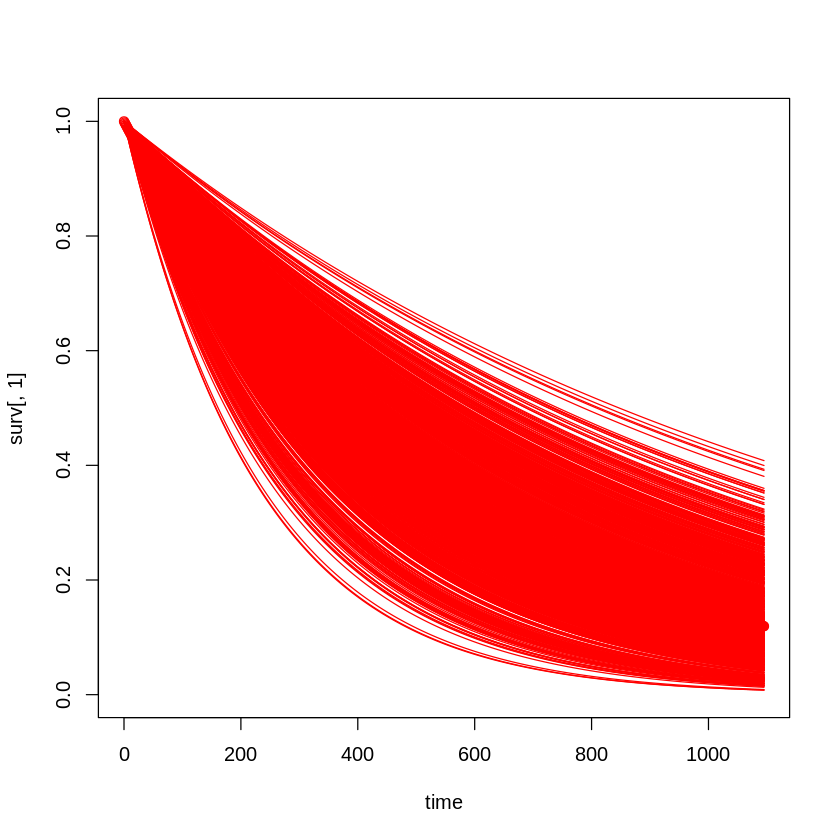

In [59]:
surv = exp(-hazard)
plot(time,surv[,1],col='red',ylim=c(0,1))
for(i in 2:nbrPats){
  lines(time,surv[,i],col='red')
}

Now need to simulate survival times by using probabilities taken from a uniform random number generator for each patient

They then survive until the corresponding time equating to the survival probability calculated from their individual hazard radio

S(t) = exp(-H_0(t) * exp(progInd)) where we calculate S(t) from random distribution for each patient

log(S(t)) = -h_0 * time * exp(progInd)

time = - log(S(t)) / h_0*exp(progInd)

In the first instance set all patinets to having an event (ie we know when all die). We can censoir later if required

In [60]:
survProb = runif(nbrPats,0,1)
patients$survTime = -log(survProb) / (h_0 * exp(patients$progInd))
patients$vitalStatus = rep(1,nbrPats)

Use survival package to plot KM curve

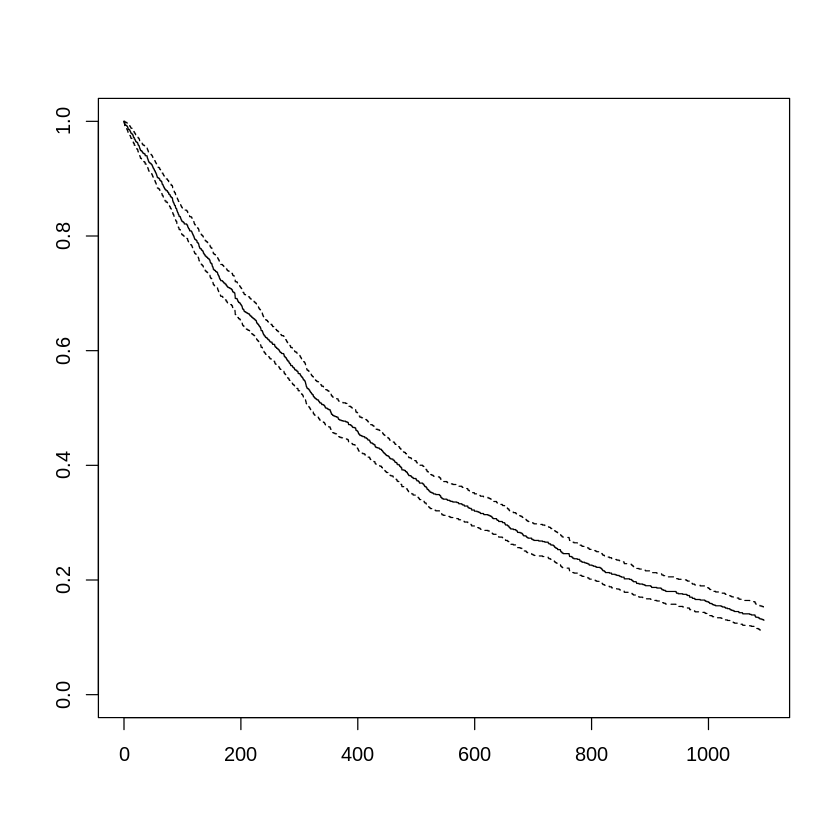

In [63]:
sampleSurv = Surv(patients$survTime,patients$vitalStatus)
plot(survfit(sampleSurv~1),xlim=c(0,3*365))

Calculate a cox model and see what the regression coefficients say

In [65]:
sampleCox = coxph(sampleSurv~ age + sex + ps + stage + log(gtv), data=patients)
summary(sampleCox)

Call:
coxph(formula = sampleSurv ~ age + sex + ps + stage + log(gtv), 
    data = patients)

  n= 1000, number of events= 1000 

             coef exp(coef) se(coef)     z Pr(>|z|)    
age      0.012344  1.012420 0.003136 3.936 8.27e-05 ***
sexmale  0.211093  1.235028 0.066066 3.195   0.0014 ** 
ps       0.201125  1.222777 0.037478 5.366 8.03e-08 ***
stage    0.179079  1.196115 0.031220 5.736 9.69e-09 ***
log(gtv) 0.017814  1.017974 0.031893 0.559   0.5765    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

         exp(coef) exp(-coef) lower .95 upper .95
age          1.012     0.9877    1.0062     1.019
sexmale      1.235     0.8097    1.0850     1.406
ps           1.223     0.8178    1.1362     1.316
stage        1.196     0.8360    1.1251     1.272
log(gtv)     1.018     0.9823    0.9563     1.084

Concordance= 0.586  (se = 0.01 )
Likelihood ratio test= 86.13  on 5 df,   p=<2e-16
Wald test            = 87.22  on 5 df,   p=<2e-16
Score (logrank) test = 87.46  on 

In first scenario, randomise patients into 2 cohorts. Give cohort 1 the treatment, recalculate prognostic index including treatment HR and show KM curve stratified on treatment

In second scenario, assign based on stage / PS and look for effect. Will need to think of a condounder that correlated with one of these variables for the actual analysis

In [78]:
patients$treatment_assignment = rep('SoC',nbrPats)
patients$treatment_assignment[which(runif(nbrPats,0,1) > 0.5)] = 'Intervention'

patients$treatment_assignment_pi = rep(log(1.0),nbrPats)
patients$treatment_assignment_pi[which(patients$treatment_assignment == 'Intervention')] = rep(log(hr_treat),sum(patients$treatment_assignment == 'Intervention'))
patients$progInd = patients$age_pi + patients$sex_pi + patients$ps_pi + patients$stage_pi + patients$log_gtv_pi + patients$treatment_assignment_pi

hazard = array(dim=c(length(time),nrow=nbrPats))
for(i in 1:nbrPats){
  hazard[,i] =  H_0 * exp(patients$progInd[i])
}

survProb = runif(nbrPats,0,1)
patients$survTime = -log(survProb) / (h_0 * exp(patients$progInd))
patients$vitalStatus = rep(1,nbrPats)


Plot randomised KM curve

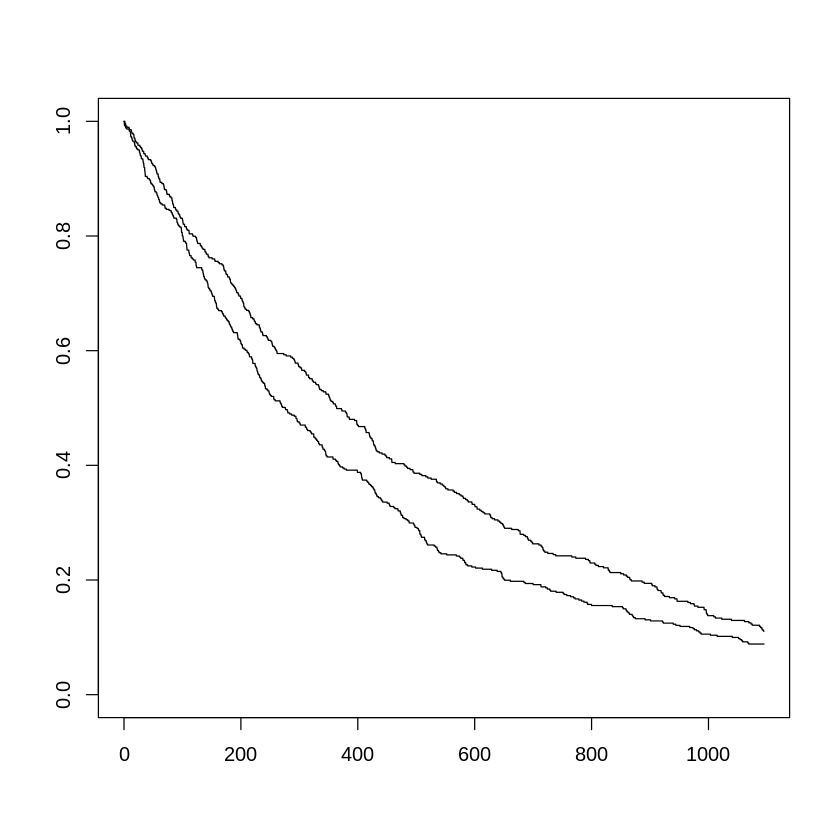

In [79]:
sampleSurv = Surv(patients$survTime,patients$vitalStatus)
plot(survfit(sampleSurv~treatment_assignment, data=patients),xlim=c(0,3*365))

Cox model

In [81]:
sampleCox = coxph(sampleSurv~ treatment_assignment, data=patients)
summary(sampleCox)

Call:
coxph(formula = sampleSurv ~ treatment_assignment, data = patients)

  n= 1000, number of events= 1000 

                            coef exp(coef) se(coef)      z Pr(>|z|)    
treatment_assignmentSoC -0.21606   0.80569  0.06377 -3.388 0.000704 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                        exp(coef) exp(-coef) lower .95 upper .95
treatment_assignmentSoC    0.8057      1.241     0.711     0.913

Concordance= 0.531  (se = 0.009 )
Likelihood ratio test= 11.5  on 1 df,   p=7e-04
Wald test            = 11.48  on 1 df,   p=7e-04
Score (logrank) test = 11.52  on 1 df,   p=7e-04


Assign treatment based on PS = 0 and plot KM

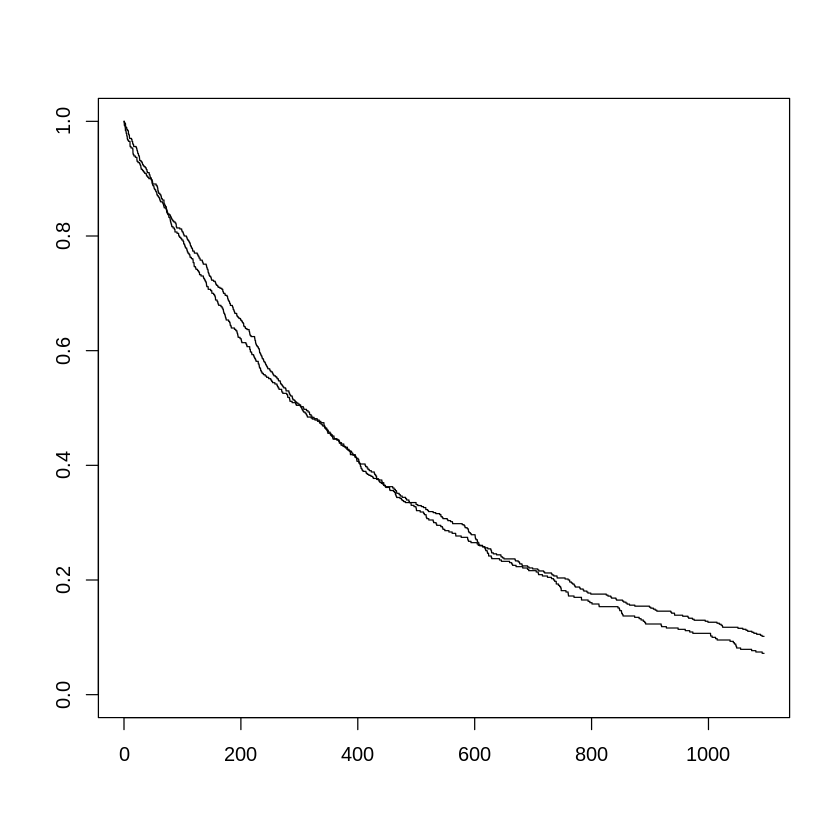

In [82]:
patients$treatment_assignment = rep('SoC',nbrPats)
patients$treatment_assignment[which(patients$ps <= 1)] = 'Intervention'

patients$treatment_assignment_pi = rep(log(1.0),nbrPats)
patients$treatment_assignment_pi[which(patients$treatment_assignment == 'Intervention')] = rep(log(hr_treat),sum(patients$treatment_assignment == 'Intervention'))
patients$progInd = patients$age_pi + patients$sex_pi + patients$ps_pi + patients$stage_pi + patients$log_gtv_pi + patients$treatment_assignment_pi

hazard = array(dim=c(length(time),nrow=nbrPats))
for(i in 1:nbrPats){
  hazard[,i] =  H_0 * exp(patients$progInd[i])
}

survProb = runif(nbrPats,0,1)
patients$survTime = -log(survProb) / (h_0 * exp(patients$progInd))
patients$vitalStatus = rep(1,nbrPats)

sampleSurv = Surv(patients$survTime,patients$vitalStatus)
plot(survfit(sampleSurv~treatment_assignment, data=patients),xlim=c(0,3*365))


In [83]:
sampleCox = coxph(sampleSurv~ treatment_assignment, data=patients)
summary(sampleCox)

Call:
coxph(formula = sampleSurv ~ treatment_assignment, data = patients)

  n= 1000, number of events= 1000 

                           coef exp(coef) se(coef)     z Pr(>|z|)
treatment_assignmentSoC 0.08043   1.08375  0.06410 1.255     0.21

                        exp(coef) exp(-coef) lower .95 upper .95
treatment_assignmentSoC     1.084     0.9227    0.9558     1.229

Concordance= 0.507  (se = 0.009 )
Likelihood ratio test= 1.57  on 1 df,   p=0.2
Wald test            = 1.57  on 1 df,   p=0.2
Score (logrank) test = 1.58  on 1 df,   p=0.2
